## Multi-Platform Analysis with Python

### Tyler Wixtrom

In this notebook, we will use existing libraries for data processing an analysis to examine near-surface wind characteristics in both an observed and modeled dataset. To get started, we first set up a dask client and import some required libraries.

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:50004")
client

Client Scheduler: tcp://127.0.0.1:50004 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.59 GB


In [2]:
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, LogLocator
from metpy.units import units
from metpy.interpolate import interpolate_1d
import numpy as np
import pandas as pd
import xarray as xr

### Datasets

The datasets in this example come from a case study conducted at the Texas Tech University Reese Technology Center in Lubbock, TX on 7 May, 2019. Included is a timeseries from the 200m instrumented tower and a timeseries from a high-resolution numerical simulation at the nearest grid point. Both observed and simulated timeseries have been previously converted from raw output text.

In [3]:
wrf = xr.open_dataset('model_data_file.nc', chunks={'time': 10000})
tower = xr.open_dataset('observations_data_file.nc', chunks={'time': 10000})

The simulated timeseries is longer than the observed timeseries, so we will select only the times that overlap with the observation times. We will also calculate wind speed from the u and v components.

In [4]:
# Subset to keep only time of interest
wrf_subset = wrf.sel(time=slice('2019-05-07T19:00:00', '2019-05-07T22:00:01'))

# Calculate wind speed
wrf_subset['wind_speed'] = (wrf_subset['u_component_of_wind']**2 + wrf_subset['v_component_of_wind']**2)**0.5
wrf_subset['wind_speed'].attrs['units'] = wrf_subset.u_component_of_wind.units

### 10-m Wind Speed (1-Min Average)

The observed timeseries is sampled at 50 Hz, while the simulated timeseries has output approximately every 1.3 s. To compare, we need to align the two in time for plotting. The best method is to resample by averaging over a common period. In this example, we will choose a 1-min averaging time. This is commonly used when determining the sustained wind. 

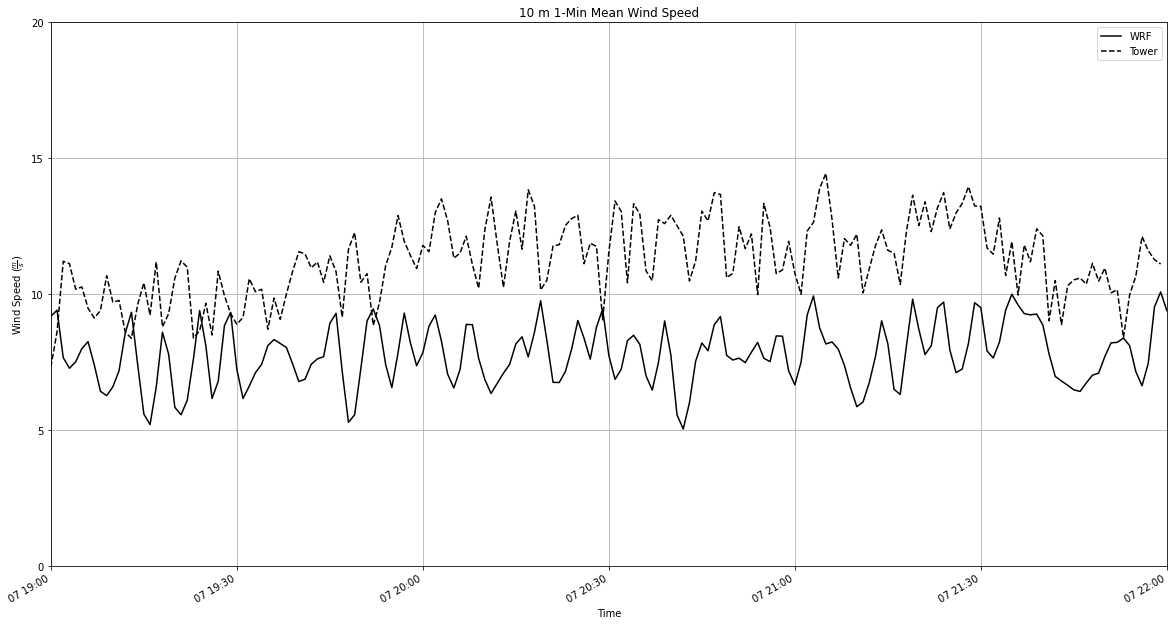

In [5]:
# Create figure
fig = plt.figure(figsize=(20,10))

# Interpolate tower winds to 10m
ts_tower = tower['sonic_wind_speed'].interp(level=10)
ts_wrf = wrf_subset['wind_speed'].interp(height=10)

# Calculate 1-min average for tower and model
mean_ts_wrf = ts_wrf.resample(time='1Min').mean()
mean_ts_tower = ts_tower.resample(time='1Min').mean()

# Use xarrays built-in plotting to start the plot
plot = mean_ts_wrf.plot(color='k', label='WRF')

# Add tower timeseries
plt.plot(mean_ts_tower.time, mean_ts_tower.compute(), color='k', label='Tower', linestyle='--')

# Configure the plot labels and style
plt.xlabel('Time')
plt.ylabel('Wind Speed ($\\frac{m}{s}$)')
plt.ylim(0, 20)
plt.yticks(range(0, 21, 5))
plt.xlim(pd.Timestamp('2019-05-07T19:00:00'), pd.Timestamp('2019-05-07T22:00:00'))
plt.grid()
plt.legend()
plt.title('10 m 1-Min Mean Wind Speed')
plt.show()

### Wind Speed and Variance Profiles
The vertical profile of wind speed and variance (averaged in time) is often of interest in boundary layer meteorology. This is easy to do by computing the mean for each dataset in only the time dimension. 

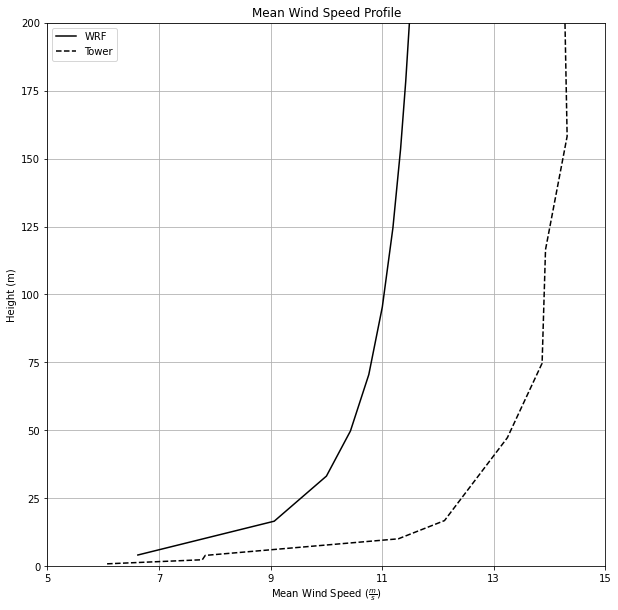

In [6]:
# Mean wind profile
fig = plt.figure(figsize=(10,10))

# Calculate mean in time
wrf_mean = wrf_subset['wind_speed'].mean(dim='time').where(wrf_subset.height <= 210)
tower_mean = tower.sonic_wind_speed.mean(dim='time')

# Create plot
plot = wrf_mean.plot(y='height', x=None, color='k', label='WRF')
plt.plot(tower_mean.compute(), tower_mean.level, color='k', label='Tower', linestyle='--')

# Add labels
plt.yticks(np.arange(0, 201, 25))
plt.ylim(0, 200)
plt.xlim(5,15)
plt.xticks(range(5, 16, 2))
plt.xlabel('Mean Wind Speed ($\\frac{m}{s}$)')
plt.ylabel('Height (m)')
plt.grid()
plt.legend()
plt.title('Mean Wind Speed Profile')
plt.show()

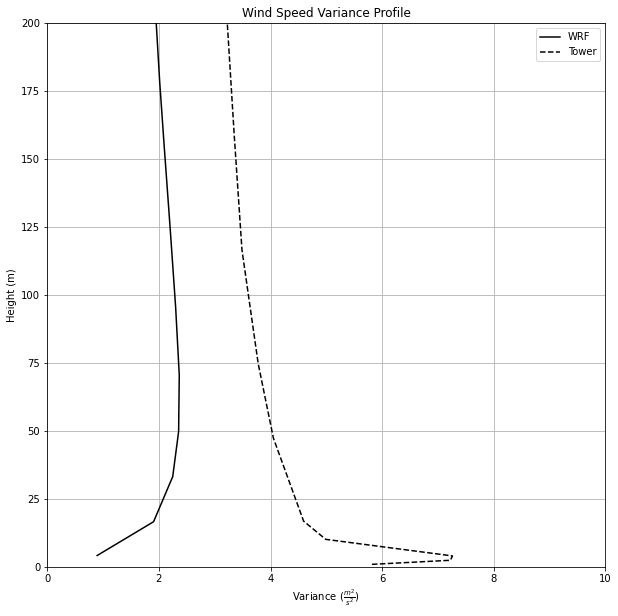

In [7]:
# Wind variance profile
fig = plt.figure(figsize=(10,10))

# Calculate variance in time
wrf_var = wrf_subset['wind_speed'].var(dim='time').where(wrf_subset.height <= 210)
tower_var = tower.sonic_wind_speed.var(dim='time')

# Create plot
plot = wrf_var.plot(y='height', x=None, color='k', label='WRF')
plt.plot(tower_var.compute(), tower_var.level, color='k', label='Tower', linestyle='--')

# Add labels
plt.yticks(np.arange(0, 201, 25))
plt.ylim(0, 200)
plt.xlim(0,10)
plt.xticks(range(0, 11, 2))
plt.xlabel('Variance ($\\frac{m^2}{s^2}$)')
plt.ylabel('Height (m)')
plt.grid()
plt.legend()
plt.title('Wind Speed Variance Profile')
plt.show()